In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np

def sklearn_normalize(data, method='standard'):
    """
    Use sklearn for more robust normalization
    """
    # Reshape to 2D: [time*patient, variable]
    n_time, n_patient, n_var = data.shape
    data_2d = data.reshape(-1, n_var)
    
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'robust':
        scaler = RobustScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("method must be 'standard', 'robust', or 'minmax'")
    
    normalized_2d = scaler.fit_transform(data_2d)
    return normalized_2d.reshape(n_time, n_patient, n_var), scaler

In [2]:
X = np.load('../data/actual_data/csf_longtid.npy')
mu = np.nanmean(X, axis=(0,1))      # mean per variable
sigma = np.nanstd(X, axis=(0,1))    # std per variable
X_norm = (X - mu) / sigma

X_norm

array([[[ 7.93985200e-01,  1.00656527e+00,  6.23058491e-01, ...,
         -3.19728230e-04, -1.07448470e+00,  8.23486691e-01],
        [ 7.04938637e-01,  1.00656527e+00, -5.37238396e-01, ...,
         -2.69777607e-01, -1.70942594e-01,  1.49378521e-01],
        [ 1.01509234e+00,  1.00656527e+00,  6.23058491e-01, ...,
         -7.49136637e-01, -1.30840172e+00,  8.23486691e-01],
        ...,
        [ 4.01079441e-02,  1.00656527e+00,  1.39658975e+00, ...,
         -8.22493094e-01, -2.71336162e-01,  8.23486691e-01],
        [ 1.01660161e+00,  1.00656527e+00,  6.23058491e-01, ...,
         -8.57355569e-01,  2.77360075e+00, -2.21000008e+00],
        [ 6.06081860e-01, -9.93477547e-01, -9.24004024e-01, ...,
         -2.04410467e-01, -2.38206285e-01, -1.87675564e-01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             

In [15]:
def remove_outlier_samples_future(data, iqr_multiplier=1.5):
    """
    Remove samples containing outliers for each time point using IQR, dropping them from future time points.
    Parameters:
        data: 3D NumPy array [time points, samples, variables]
        iqr_multiplier: Multiplier for IQR (default 1.5 for standard outlier detection)
    Returns:
        data_cleaned: List of 2D arrays for each time point with outlier samples removed
        valid_indices: List of sample indices kept for each time point
    """
    time_points, samples, variables = data.shape
    data_cleaned = []
    valid_indices = []
    # Track invalid samples globally (outliers at any time point)
    invalid_samples = set()
    
    for t in range(time_points):
        # Extract data for the current time point: shape [samples, variables]
        time_data = data[t, :, :]
        
        # Initialize mask for valid samples (True means keep)
        valid_mask = np.ones(samples, dtype=bool)
        # Mark previously identified invalid samples as False
        for invalid_idx in invalid_samples:
            valid_mask[invalid_idx] = False
        
        # Check each variable for outliers
        for var_idx in range(variables):
            var_data = time_data[:, var_idx]
            
            # Compute Q1, Q3, and IQR for the variable at this time point
            Q1 = np.percentile(var_data[valid_mask], 2)
            Q3 = np.percentile(var_data[valid_mask], 98)
            IQR = Q3 - Q1
            
            # Define outlier bounds
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            
            # Mark outliers in the valid mask
            outliers = (var_data < lower_bound) | (var_data > upper_bound)
            valid_mask = valid_mask & ~outliers
        
        # Update global invalid samples
        invalid_samples.update(np.where(~valid_mask)[0])
        
        # Keep only valid samples
        valid_time_data = time_data[valid_mask, :]
        valid_idx = np.where(valid_mask)[0]
        
        data_cleaned.append(valid_time_data)
        valid_indices.append(valid_idx)
    
    return data_cleaned, valid_indices

# Example usage
# Remove samples with outliers
data_cleaned, valid_indices = remove_outlier_samples_future(bb, iqr_multiplier=1)
data_cleaned = np.stack(data_cleaned, axis=0)  # Convert list of arrays back to 3D array
data_cleaned.shape


ValueError: not enough values to unpack (expected 3, got 2)

In [5]:
X_norm

array([[[ 7.93985200e-01,  1.00656527e+00,  6.23058491e-01, ...,
         -3.19728230e-04, -1.07448470e+00,  8.23486691e-01],
        [ 7.04938637e-01,  1.00656527e+00, -5.37238396e-01, ...,
         -2.69777607e-01, -1.70942594e-01,  1.49378521e-01],
        [ 1.01509234e+00,  1.00656527e+00,  6.23058491e-01, ...,
         -7.49136637e-01, -1.30840172e+00,  8.23486691e-01],
        ...,
        [ 4.01079441e-02,  1.00656527e+00,  1.39658975e+00, ...,
         -8.22493094e-01, -2.71336162e-01,  8.23486691e-01],
        [ 1.01660161e+00,  1.00656527e+00,  6.23058491e-01, ...,
         -8.57355569e-01,  2.77360075e+00, -2.21000008e+00],
        [ 6.06081860e-01, -9.93477547e-01, -9.24004024e-01, ...,
         -2.04410467e-01, -2.38206285e-01, -1.87675564e-01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             

In [9]:
from mcmc_bspline_speed_mod import BN_LTE_MCMC_BSpline_Optimized

chain_list = []
static_idx = [0, 1, 2, 3]  # AGE, PTEDUCAT, PTGENDER, APOE41
static_idx = np.array(static_idx)
res = []
for i in range(X_norm.shape[2]):
    res.append((i, -1))
    res.append((i, -2))

for i in range(X_norm.shape[0]):
    X = X_norm[i]
    print(X.shape)
    # keep only non-NaN values but store indices
    valid_indices = ~np.isnan(X).any(axis=1)
    X = X[valid_indices]
    print(X.shape)
    sampler = BN_LTE_MCMC_BSpline_Optimized(X, seed=0, static_features=static_idx, forbidden_edges=res,
                                            K_edge=5, K_baseline=5,  degree=3)
    chain   = sampler.run(n_iter=2000, burnin=100, thin=2)
    chain_list.append(chain)
    print(f"Finished processing sample {i}")

(1162, 13)
(1162, 13)
PCA direction: 1.0


/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encounter

iter    10 │ z‑accept = 66.61% │ z‑step = 0.4000
iter    20 │ z‑accept = 42.95% │ z‑step = 0.4000
iter    30 │ z‑accept = 34.86% │ z‑step = 0.4000
iter    40 │ z‑accept = 33.60% │ z‑step = 0.4000
iter    50 │ z‑accept = 31.64% │ z‑step = 0.4000
iter    60 │ z‑accept = 30.89% │ z‑step = 0.4200
iter    70 │ z‑accept = 29.35% │ z‑step = 0.4410
iter    80 │ z‑accept = 25.59% │ z‑step = 0.4631
iter    90 │ z‑accept = 23.80% │ z‑step = 0.4862
iter   100 │ z‑accept = 22.91% │ z‑step = 0.4619
iter   110 │ z‑accept = 23.46% │ z‑step = 0.4388
iter   120 │ z‑accept = 23.98% │ z‑step = 0.4169
iter   130 │ z‑accept = 22.56% │ z‑step = 0.3960
iter   140 │ z‑accept = 23.06% │ z‑step = 0.3762
iter   150 │ z‑accept = 22.44% │ z‑step = 0.3574
iter   160 │ z‑accept = 23.02% │ z‑step = 0.3395
iter   170 │ z‑accept = 23.41% │ z‑step = 0.3226
iter   180 │ z‑accept = 23.82% │ z‑step = 0.3064
iter   190 │ z‑accept = 24.35% │ z‑step = 0.2911
iter   200 │ z‑accept = 25.18% │ z‑step = 0.2766
iter   210 │ z‑accep

/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encounter

iter    10 │ z‑accept = 67.67% │ z‑step = 0.4000
iter    20 │ z‑accept = 47.83% │ z‑step = 0.4000
iter    30 │ z‑accept = 38.81% │ z‑step = 0.4000
iter    40 │ z‑accept = 34.86% │ z‑step = 0.4000
iter    50 │ z‑accept = 33.75% │ z‑step = 0.4000
iter    60 │ z‑accept = 34.03% │ z‑step = 0.4200
iter    70 │ z‑accept = 32.71% │ z‑step = 0.4410
iter    80 │ z‑accept = 31.76% │ z‑step = 0.4631
iter    90 │ z‑accept = 30.93% │ z‑step = 0.4862
iter   100 │ z‑accept = 29.15% │ z‑step = 0.5000
iter   110 │ z‑accept = 28.73% │ z‑step = 0.5000
iter   120 │ z‑accept = 29.59% │ z‑step = 0.5000
iter   130 │ z‑accept = 29.59% │ z‑step = 0.5000
iter   140 │ z‑accept = 30.39% │ z‑step = 0.5000
iter   150 │ z‑accept = 29.43% │ z‑step = 0.5000
iter   160 │ z‑accept = 29.95% │ z‑step = 0.5000
iter   170 │ z‑accept = 29.59% │ z‑step = 0.5000
iter   180 │ z‑accept = 29.43% │ z‑step = 0.5000
iter   190 │ z‑accept = 28.86% │ z‑step = 0.5000
iter   200 │ z‑accept = 30.57% │ z‑step = 0.5000
iter   210 │ z‑accep

/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: divide by zero encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: overflow encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: invalid value encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:508: RuntimeWarning: divide by zero encountered in matmul
  A = D.T @ D  # m x m
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:508: RuntimeWarning: overflow encountered in matmul
  A = D.T @ D  # m x m
/Users/nataliaglazman/Desktop/PhD/

iter    10 │ z‑accept = 59.26% │ z‑step = 0.4000
iter    20 │ z‑accept = 37.89% │ z‑step = 0.4000
iter    30 │ z‑accept = 28.00% │ z‑step = 0.4000
iter    40 │ z‑accept = 30.11% │ z‑step = 0.4000
iter    50 │ z‑accept = 33.89% │ z‑step = 0.4000
iter    60 │ z‑accept = 28.84% │ z‑step = 0.4200
iter    70 │ z‑accept = 26.21% │ z‑step = 0.4410
iter    80 │ z‑accept = 26.95% │ z‑step = 0.4631
iter    90 │ z‑accept = 29.05% │ z‑step = 0.4862
iter   100 │ z‑accept = 26.95% │ z‑step = 0.5000
iter   110 │ z‑accept = 29.05% │ z‑step = 0.5000
iter   120 │ z‑accept = 26.53% │ z‑step = 0.5000
iter   130 │ z‑accept = 25.79% │ z‑step = 0.5000
iter   140 │ z‑accept = 25.68% │ z‑step = 0.5000
iter   150 │ z‑accept = 28.00% │ z‑step = 0.5000
iter   160 │ z‑accept = 26.84% │ z‑step = 0.5000
iter   170 │ z‑accept = 30.95% │ z‑step = 0.5000
iter   180 │ z‑accept = 27.89% │ z‑step = 0.5000
iter   190 │ z‑accept = 24.63% │ z‑step = 0.5000
iter   200 │ z‑accept = 25.37% │ z‑step = 0.4750
iter   210 │ z‑accep

/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: divide by zero encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: overflow encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: invalid value encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T


iter    10 │ z‑accept = 47.86% │ z‑step = 0.4000
iter    20 │ z‑accept = 25.36% │ z‑step = 0.4000
iter    30 │ z‑accept = 20.36% │ z‑step = 0.4000
iter    40 │ z‑accept = 23.93% │ z‑step = 0.4000
iter    50 │ z‑accept = 17.86% │ z‑step = 0.4000
iter    60 │ z‑accept = 16.79% │ z‑step = 0.3800
iter    70 │ z‑accept = 17.14% │ z‑step = 0.3610
iter    80 │ z‑accept = 21.07% │ z‑step = 0.3429
iter    90 │ z‑accept = 20.36% │ z‑step = 0.3258
iter   100 │ z‑accept = 15.36% │ z‑step = 0.3095
iter   110 │ z‑accept = 15.00% │ z‑step = 0.2940
iter   120 │ z‑accept = 15.36% │ z‑step = 0.2793
iter   130 │ z‑accept = 20.36% │ z‑step = 0.2654
iter   140 │ z‑accept = 22.86% │ z‑step = 0.2521
iter   150 │ z‑accept = 27.86% │ z‑step = 0.2395
iter   160 │ z‑accept = 32.14% │ z‑step = 0.2515
iter   170 │ z‑accept = 33.57% │ z‑step = 0.2640
iter   180 │ z‑accept = 26.07% │ z‑step = 0.2772
iter   190 │ z‑accept = 25.71% │ z‑step = 0.2911
iter   200 │ z‑accept = 33.21% │ z‑step = 0.3057
iter   210 │ z‑accep

/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:508: RuntimeWarning: divide by zero encountered in matmul
  A = D.T @ D  # m x m
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:508: RuntimeWarning: overflow encountered in matmul
  A = D.T @ D  # m x m
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:508: RuntimeWarning: invalid value encountered in matmul
  A = D.T @ D  # m x m


iter   350 │ z‑accept = 23.21% │ z‑step = 0.2853
iter   360 │ z‑accept = 20.71% │ z‑step = 0.2711
iter   370 │ z‑accept = 22.14% │ z‑step = 0.2575
iter   380 │ z‑accept = 20.71% │ z‑step = 0.2446
iter   390 │ z‑accept = 33.57% │ z‑step = 0.2324
iter   400 │ z‑accept = 38.21% │ z‑step = 0.2440
iter   410 │ z‑accept = 29.29% │ z‑step = 0.2562
iter   420 │ z‑accept = 29.29% │ z‑step = 0.2690
iter   430 │ z‑accept = 28.57% │ z‑step = 0.2825
iter   440 │ z‑accept = 30.71% │ z‑step = 0.2966
iter   450 │ z‑accept = 31.07% │ z‑step = 0.3114
iter   460 │ z‑accept = 22.50% │ z‑step = 0.3270
iter   470 │ z‑accept = 27.14% │ z‑step = 0.3107
iter   480 │ z‑accept = 30.36% │ z‑step = 0.3262
iter   490 │ z‑accept = 23.21% │ z‑step = 0.3425
iter   500 │ z‑accept = 25.36% │ z‑step = 0.3254
iter   510 │ z‑accept = 22.86% │ z‑step = 0.3417
iter   520 │ z‑accept = 28.57% │ z‑step = 0.3246
iter   530 │ z‑accept = 25.00% │ z‑step = 0.3408
iter   540 │ z‑accept = 23.93% │ z‑step = 0.3238
iter   550 │ z‑accep

/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: divide by zero encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: overflow encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:396: RuntimeWarning: invalid value encountered in matmul
  self._baseline_contrib = self._basis_gamma @ self.state.gamma.T


iter    20 │ z‑accept = 16.25% │ z‑step = 0.4000
iter    30 │ z‑accept = 13.75% │ z‑step = 0.4000
iter    40 │ z‑accept = 7.50% │ z‑step = 0.4000
iter    50 │ z‑accept = 3.75% │ z‑step = 0.4000
iter    60 │ z‑accept = 6.25% │ z‑step = 0.3800
iter    70 │ z‑accept = 2.50% │ z‑step = 0.3610
iter    80 │ z‑accept = 1.25% │ z‑step = 0.3429
iter    90 │ z‑accept = 1.25% │ z‑step = 0.3258
iter   100 │ z‑accept = 2.50% │ z‑step = 0.3095
iter   110 │ z‑accept = 2.50% │ z‑step = 0.2940
iter   120 │ z‑accept = 3.75% │ z‑step = 0.2793
iter   130 │ z‑accept = 6.25% │ z‑step = 0.2654
iter   140 │ z‑accept = 3.75% │ z‑step = 0.2521
iter   150 │ z‑accept = 1.25% │ z‑step = 0.2395
iter   160 │ z‑accept = 3.75% │ z‑step = 0.2275
iter   170 │ z‑accept = 3.75% │ z‑step = 0.2161
iter   180 │ z‑accept = 2.50% │ z‑step = 0.2053
iter   190 │ z‑accept = 2.50% │ z‑step = 0.1951
iter   200 │ z‑accept = 2.50% │ z‑step = 0.1853
iter   210 │ z‑accept = 10.00% │ z‑step = 0.1761
iter   220 │ z‑accept = 6.25% │ z‑ste

/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_pca.py:586: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/scipy/stats/_multivariate.py:762: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Residuals: [70.51423146]
iter    20 │ z‑accept = 0.00% │ z‑step = 0.4000
iter    30 │ z‑accept = 0.00% │ z‑step = 0.4000
Residuals: [100.81315243]
Residuals: [37.51816049]
Residuals: [11.67915146]
iter    40 │ z‑accept = 0.00% │ z‑step = 0.4000
iter    50 │ z‑accept = 0.00% │ z‑step = 0.4000
iter    60 │ z‑accept = 0.00% │ z‑step = 0.3800
iter    70 │ z‑accept = 0.00% │ z‑step = 0.3610
iter    80 │ z‑accept = 0.00% │ z‑step = 0.3429
Residuals: [-14.80358983]
iter    90 │ z‑accept = 0.00% │ z‑step = 0.3258
iter   100 │ z‑accept = 0.00% │ z‑step = 0.3095
iter   110 │ z‑accept = 0.00% │ z‑step = 0.2940
iter   120 │ z‑accept = 10.00% │ z‑step = 0.2793
iter   130 │ z‑accept = 0.00% │ z‑step = 0.2654
Residuals: [-38.23689167]
iter   140 │ z‑accept = 0.00% │ z‑step = 0.2521
Residuals: [81.194601]
iter   150 │ z‑accept = 0.00% │ z‑step = 0.2395
Residuals: [62.23043217]
Residuals: [30.14971795]
iter   160 │ z‑accept = 0.00% │ z‑step = 0.2275
iter   170 │ z‑accept = 0.00% │ z‑step = 0.2161
iter 

In [14]:
draws1 = chain_list[0]

In [ ]:
from scripts.mcmc_bspline_speed_mod import BN_LTE_MCMC_BSpline_Optimized

sampler = BN_LTE_MCMC_BSpline_Optimized(X_norm[0], seed=0, static_features=static_idx, forbidden_edges=res,
                                K_edge=5, K_baseline=5,  degree=3)
chain   = sampler.run(n_iter=2000, burnin=100, thin=2)

/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_spe

PCA direction: -1.0


/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:530: RuntimeWarning: divide by zero encountered in matmul
  y -= D[:, mask] @ self.state.beta[j, l, mask]
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:530: RuntimeWarning: overflow encountered in matmul
  y -= D[:, mask] @ self.state.beta[j, l, mask]
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:530: RuntimeWarning: invalid value encountered in matmul
  y -= D[:, mask] @ self.state.beta[j, l, mask]
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:551: RuntimeWarning: divide by zero encountered in matmul
  y -= D_act @ beta_draw
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mod.py:551: RuntimeWarning: overflow encountered in matmul
  y -= D_act @ beta_draw
/Users/nataliaglazman/Desktop/PhD/work/bnlte-extension/scripts/mcmc_bspline_speed_mo

iter    10 │ z‑accept = 80.55% │ z‑step = 0.2000
iter    20 │ z‑accept = 71.03% │ z‑step = 0.2100
iter    30 │ z‑accept = 65.21% │ z‑step = 0.2205


KeyboardInterrupt: 

In [ ]:
from scripts.mcmc_bspline_speed_mod_old import BN_LTE_MCMC_BSpline_Optimized
from joblib import Parallel, delayed

def run_single_chain(X, chain_id, *,
                     n_iter=10000, burnin=1000, thin=100,
                     **sampler_kwargs):
    """Run ONE BN_LTE_MCMC chain and return the list of thinned State objects."""
    sampler = BN_LTE_MCMC_BSpline_Optimized(bb, seed=chain_id, static_features=static_idx, forbidden_edges=res, 
                                K_edge=7, K_baseline=5,  degree=3, scaler=scaler)
    chain   = sampler.run(n_iter=n_iter, burnin=burnin, thin=thin)
    return chain

N_CHAINS       = 4
COMMON_KWARGS  = dict(seed=1)

chains = Parallel(n_jobs=N_CHAINS)(
    delayed(run_single_chain)(
        X, cid, n_iter=700, burnin=100, thin=2
    )
    for cid in range(N_CHAINS)
)
print(f"Finished {N_CHAINS} chains.")

/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/causallearn/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: inv

PCA direction: -1.0
PCA direction: -1.0PCA direction: -1.0

PCA direction: -1.0
iter    10 │ z‑accept = 80.55% │ z‑step = 0.2000
iter    10 │ z‑accept = 78.78% │ z‑step = 0.2000
iter    10 │ z‑accept = 79.93% │ z‑step = 0.2000
iter    10 │ z‑accept = 80.32% │ z‑step = 0.2000
iter    20 │ z‑accept = 71.03% │ z‑step = 0.2100
iter    20 │ z‑accept = 76.93% │ z‑step = 0.2100
iter    20 │ z‑accept = 72.20% │ z‑step = 0.2100
iter    20 │ z‑accept = 77.66% │ z‑step = 0.2100
iter    30 │ z‑accept = 65.21% │ z‑step = 0.2205
iter    30 │ z‑accept = 61.58% │ z‑step = 0.2205
iter    30 │ z‑accept = 71.61% │ z‑step = 0.2205
iter    30 │ z‑accept = 69.36% │ z‑step = 0.2205
iter    40 │ z‑accept = 57.45% │ z‑step = 0.2315
iter    40 │ z‑accept = 57.61% │ z‑step = 0.2315
iter    40 │ z‑accept = 61.47% │ z‑step = 0.2315
iter    40 │ z‑accept = 61.42% │ z‑step = 0.2315
iter    50 │ z‑accept = 55.41% │ z‑step = 0.2431
iter    50 │ z‑accept = 56.40% │ z‑step = 0.2431
iter    50 │ z‑accept = 52.27% │ z‑ste

In [18]:
cols = ['AGE','PTGENDER', 'PTEDUCAT',  'APOE41',

       'Intracranial Volume', 'Hippocampus', 'Amygdala', 'Temporal Lobe',
'ABETA42', 'TAU', 'PTAU',
       'TOTAL13', 'MMSCORE']

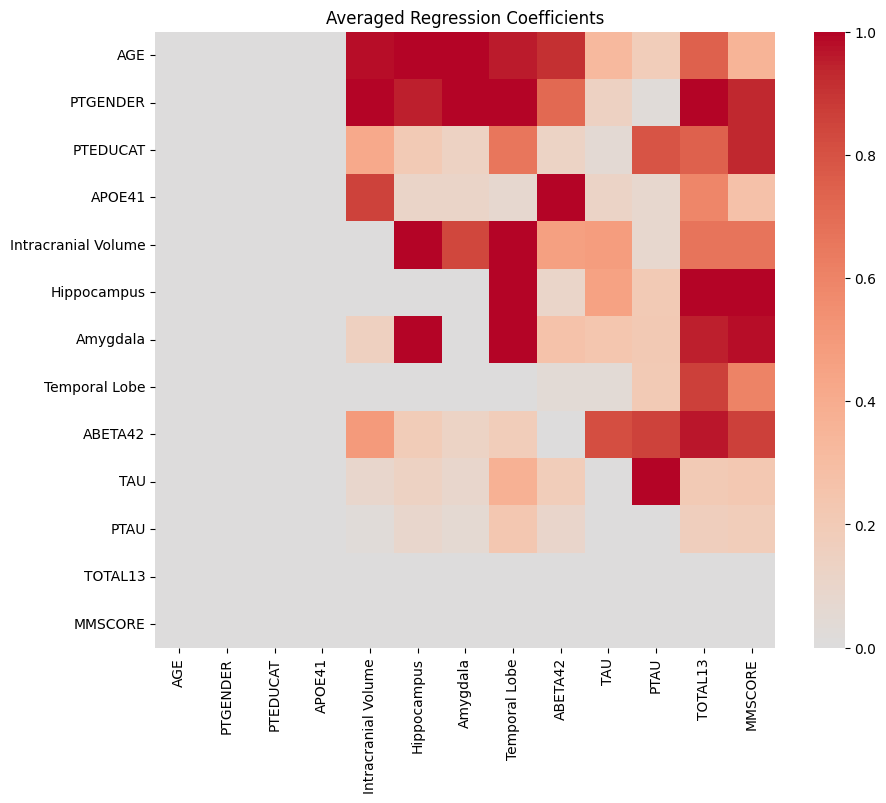

In [19]:
beta_averaged = np.mean([sampler.state.r.any(axis=2) for sampler.state in draws1], axis=0)
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(beta_averaged.T, cmap='coolwarm', center=0,
            xticklabels=cols, yticklabels=cols)
plt.title('Averaged Regression Coefficients')
plt.show()

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mcmc_bspline_progress import bspline_basis_single_row

def plot_gamma_effects(sampler, chain):
    """Plot baseline effect of gamma for each biomarker across pseudotime."""
    # Extract parameters
    p = sampler.p  # Number of biomarkers
    K_gamma = sampler.K_gamma  # Number of B-spline basis functions for gamma
    degree = sampler.degree  # B-spline degree
    t_gamma = sampler.t_gamma  # Knots for gamma

    # Compute average gamma from chain
    gamma_samples = np.array([state.gamma for state in chain])  # Shape: (n_draws, p, K_gamma)
    gamma_average = np.mean(gamma_samples, axis=0)  # Shape: (p, K_gamma)

    # Pseudotime grid
    z_grid = np.linspace(0.1, 0.9, 100)  # Typical range for z_time

    # Compute baseline effects
    baseline_effects = np.zeros((p, len(z_grid)))  # Shape: (p, len(z_grid))
    for j in range(p):
        for i, z in enumerate(z_grid):
            b_gamma = bspline_basis_single_row(z, K=K_gamma, degree=degree, t=t_gamma)  # Shape: (K_gamma,)
            baseline_effects[j, i] = b_gamma @ gamma_average[j]  # Dot product

    # Plot
    plt.figure(figsize=(10, 6))
    for j in range(p):
        plt.plot(z_grid, baseline_effects[j], label=f'Biomarker {cols[j]}')
    plt.xlabel('Pseudotime (z)')
    plt.ylabel('Baseline Effect')
    plt.title('Baseline Effect of Gamma on Each Biomarker')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('gamma_effects.png')
    plt.show()

# Example usage
plot_gamma_effects(sampler, chain)


ModuleNotFoundError: No module named 'mcmc_bspline_progress'

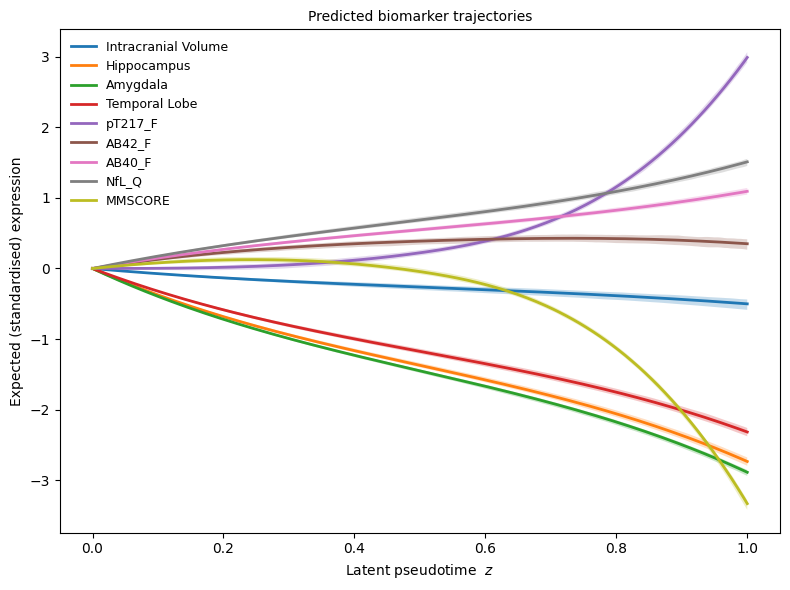

In [44]:
# %% PLOT MULTIPLE BIOMARKER TRAJECTORIES
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler            # nicer automatic colours

# ── user knobs ─────────────────────────────────────────────────────────
biomarkers = [4, 5, 6, 7, 8, 9, 10, 11, -1]      # list of indices you want to see
add_average = False          # also plot the cohort average trajectory
cred        = 0.20          # band level (same for every curve)
n_grid      = 200           # z-axis resolution
# ───────────────────────────────────────────────────────────────────────

# helper – same cubic B-spline basis as the sampler
def bspline_basis(z, *, K, degree=3, t=None):
    from scipy.interpolate import BSpline
    z = np.asarray(z, float)
    n_internal = K - degree - 1
    if t is None:
        internal = np.linspace(0, 1, n_internal + 2)[1:-1]
        t = np.r_[np.zeros(degree + 1), internal, np.ones(degree + 1)]
    B = np.empty((len(z), K))
    for k in range(K):
        coeff = np.zeros(K)
        coeff[k] = 1.0
        B[:, k] = BSpline(t, coeff, degree)(z)
    return B, t



z_grid   = np.linspace(0, 1, n_grid)
B_grid, _ = bspline_basis(z_grid, K=sampler.K_beta, degree=3)
B_grid_g, _ = bspline_basis(z_grid, K=sampler.K_gamma, degree=3)

# assemble a dict {label: (mean, lower, upper)}
traj_dict = {}

# NEW: centre each raw trajectory so that the first point is zero
def summarise_traj(raw_traj):
    """
    raw_traj : array (n_draws × n_grid)
    Returns   : mean, lower, upper arrays on the *same* z_grid,
                each shifted so that value at z=0 is 0.
    """
    centred = raw_traj - raw_traj[:, [0]]    # subtract value at z=0 (broadcast)
    m  = centred.mean(0)
    lo, hi = np.quantile(centred, [(1-cred)/2, 1-(1-cred)/2], axis=0)
    return m, lo, hi

# (1) individual biomarkers
for j in biomarkers:
    raw = np.vstack([B_grid_g @ s.gamma[j] for s in chain])
    traj_dict[f"{cols[j]}"] = summarise_traj(raw)

# (2) optional cohort average
if add_average:
    raw = np.vstack([(B_grid @ s.gamma.T).mean(1) for s in chain])
    traj_dict["Average"] = summarise_traj(raw)

# ---------------------------------------------------------------------
# plot
plt.figure(figsize=(8, 6))
plt.gca().set_prop_cycle(cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color']
                                * 2))            # enough distinct colours

neg_list = [11]

for label, (mean, lo, hi) in traj_dict.items():
    if label in neg_list:
        plt.plot(z_grid, -mean, lw=2, label=label)
        plt.fill_between(z_grid, -lo, -hi, alpha=0.25)
    else:
        plt.plot(z_grid, mean, lw=2, label=label)
        plt.fill_between(z_grid, lo, hi, alpha=0.25)

plt.xlabel("Latent pseudotime  $z$")
plt.ylabel("Expected (standardised) expression")
plt.title("Predicted biomarker trajectories")
plt.legend( frameon=False, ncol=1, fontsize=9)
plt.tight_layout()


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import mcmc_bspline_progress

def compute_and_plot_residuals(sampler, C_average, gamma_average, beta_average, r_average, eta_average, static_idx):
    """Compute residuals for non-static variables at t=1 and plot boxplot."""
    # Initialize list to store residuals for each non-static variable
    non_static_indices = np.where(~np.in1d(np.arange(sampler.p), static_idx))[0]
    p_non_static = len(non_static_indices)
    n_valid = np.sum(sampler.valid_time_mask[1, :])  # Number of valid subjects at t=1
    residuals = np.zeros((n_valid, p_non_static))  # Shape: (valid subjects, non-static vars)
    
    
    # Track valid subjects
    valid_subjects = np.where(sampler.valid_time_mask[1, :])[0]
    
    for idx_i, i in enumerate(valid_subjects):
        static_variables = sampler.V_norm[1, i, :]
        
        # Compute z_new in logit space for [0,1] constraint
        C_basis = mcmc_bspline_progress.additive_basis_row(
            static_variables, K=sampler.K_c, degree=3, t=sampler.t_time
        )
        # zeta = np.random.normal(loc=np.dot(C_basis, C_average), scale=eta_average[i])
        # z_new = 1 / (1 + np.exp(-zeta))  # Sigmoid ensures z_new in (0,1)
        z_new = average_z_time[1, i]
        
        # Compute B-spline basis functions
        bspline_gamma = mcmc_bspline_progress.bspline_basis_single_row(
            z_new, K=sampler.K_gamma, degree=sampler.degree, t=sampler.t_gamma
        )
        bspline_beta = mcmc_bspline_progress.bspline_basis_single_row(
            z_new, K=sampler.K_beta, degree=sampler.degree, t=sampler.t_beta
        )
        
        for idx_j, j in enumerate(non_static_indices):
            # Baseline contribution
            baseline = bspline_gamma @ gamma_average[j]
            
            # Edge contributions from X_time[0, i, l]
            edge_sum = 0.0
            for l in range(sampler.p):
                if l != j and not sampler.forbidden[j, l]:
                    coeff = beta_average[j, l] * r_average[j, l]
                    if np.any(coeff):
                        edge_sum += sampler.X_time[0, i, l] * (bspline_beta @ coeff)
            
            # Predicted value for X_time[1, i, j]
            X_next_j = baseline + edge_sum
            
            # Residual: real - predicted
            residual = np.abs(sampler.X_time[1, i, j]) - np.abs(X_next_j)
            residuals[idx_i, idx_j] = residual
            
            print(f"Subject {i}, Var {j}: Predicted={X_next_j:.4f}, Real={sampler.X_time[1, i, j]:.4f}, Residual={residual:.4f}")
    
    # Create boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(residuals, labels=[f"Var {j}" for j in non_static_indices])
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Residual')
    plt.xlabel('Variable Index')
    plt.ylabel('Residual (Real - Predicted)')
    plt.ylim(-2, 5)
    plt.title('Residuals of Predicted vs. Real Values at t=1')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save and show plot
    plt.savefig('residuals_boxplot.png')
    plt.show()
    
    # Return average residuals for inspection
    average_residuals = np.mean(residuals, axis=0)
    print(f"Average residuals per variable: {average_residuals}")
    return residuals, average_residuals

# Example usage (replace with your actual averaged MCMC samples)
seed = 1
np.random.seed(seed)
# Assuming sampler is an instance of BN_LTE_MCMC_BSpline_Optimized
# C_average, gamma_average, beta_average, r_average, eta_average should be computed from MCMC draws
# static_idx = sampler.static_features
residuals, avg_residuals = compute_and_plot_residuals(
    sampler=sampler,
    C_average=C_average,  # Shape: (d * K_c,)
    gamma_average=gamma_average,  # Shape: (p, K_gamma)
    beta_average=beta_average,  # Shape: (p, p, K_beta)
    r_average=r_average,  # Shape: (p, p, K_beta)
    eta_average=eta_average,  # Shape: (n,)
    static_idx=sampler.static_features
)

ModuleNotFoundError: No module named 'mcmc_bspline_progress'

In [46]:

import numpy as np
import matplotlib.pyplot as plt
import mcmc_bspline_progress

def compute_and_plot_variables_vs_residuals(sampler, C_average, gamma_average, beta_average, r_average, eta_average, static_idx):
    """Compute residuals and plot boxplots for real values and residuals at t=1."""
    # Initialize arrays for residuals and real values
    non_static_indices = np.where(~np.in1d(np.arange(sampler.p), static_idx))[0]
    p_non_static = len(non_static_indices)
    n_valid = np.sum(sampler.valid_time_mask[1, :])  # Number of valid subjects at t=1
    residuals = np.zeros((n_valid, p_non_static))  # Shape: (valid subjects, non-static vars)
    real_values = np.zeros((n_valid, p_non_static))  # Real X_time[1, i, j] values
    
    # Track valid subjects
    valid_subjects = np.where(sampler.valid_time_mask[1, :])[0]
    
    for idx_i, i in enumerate(valid_subjects):
        static_variables = sampler.V_norm[1, i, :]
        
        # Compute z_new in logit space for [0,1] constraint
        C_basis = mcmc_bspline_progress.additive_basis_row(
            static_variables, K=sampler.K_c, degree=3, t=sampler.t_time
        )
        C_basis = sampler.mixed_covariate_row(static_variables)
        zeta = np.random.normal(loc=np.dot(C_basis, C_average), scale=eta_average[i])
        z_new = 1 / (1 + np.exp(-zeta))  # Sigmoid ensures z_new in (0,1)
        z_new = average_z_time[1, i]
        
        # Compute B-spline basis functions
        bspline_gamma = mcmc_bspline_progress.bspline_basis_single_row(
            z_new, K=sampler.K_gamma, degree=sampler.degree, t=sampler.t_gamma
        )
        bspline_beta = mcmc_bspline_progress.bspline_basis_single_row(
            z_new, K=sampler.K_beta, degree=sampler.degree, t=sampler.t_beta
        )
        
        for idx_j, j in enumerate(non_static_indices):
            # Baseline contribution
            baseline = bspline_gamma @ gamma_average[j]
            
            # Edge contributions from X_time[0, i, l]
            edge_sum = 0.0
            for l in range(sampler.p):
                if l != j and not sampler.forbidden[j, l]:
                    coeff = beta_average[j, l] * r_average[j, l]
                    if np.any(coeff):
                        edge_sum += sampler.X_time[0, i, l] * (bspline_beta @ coeff)
            
            # Predicted value for X_time[1, i, j]
            X_next_j = baseline + edge_sum
            
            # Real value
            real_value = sampler.X_time[1, i, j]
            real_values[idx_i, idx_j] = real_value
            
            # Residual: real - predicted
            residual = np.abs(real_value) - np.abs(X_next_j)
            residuals[idx_i, idx_j] = residual
            
            print(f"Subject {i}, Var {j}: Real={real_value:.4f}, Predicted={X_next_j:.4f}, Residual={residual:.4f}")
    
    # Create side-by-side boxplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    # Boxplot for real values
    ax1.boxplot(real_values, labels=[f"Var {j}" for j in non_static_indices])
    ax1.set_xlabel('Variable Index')
    ax1.set_ylabel('Real Values (X_time[t=1])')
    ax1.set_title('Spread of Real Values')
    ax1.grid(True, alpha=0.3)
    
    # Boxplot for residuals
    ax2.boxplot(residuals, labels=[f"Var {j}" for j in non_static_indices])
    ax2.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Residual')
    ax2.set_xlabel('Variable Index')
    ax2.set_ylabel('Residual (Real - Predicted)')
    ax2.set_title('Spread of Residuals')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Comparison of Real Values and Residuals at t=1', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.ylim(-2, 5)
    
    # Save and show plot
    plt.savefig('variables_vs_residuals_boxplot.png')
    plt.show()
    
    # Return averages for inspection
    average_residuals = np.mean(residuals, axis=0)
    average_real_values = np.mean(real_values, axis=0)
    print(f"Average real values per variable: {average_real_values}")
    print(f"Average residuals per variable: {average_residuals}")
    
    return real_values, residuals, average_real_values, average_residuals

# Example usage
seed = 1
np.random.seed(seed)
# Assuming sampler is an instance of BN_LTE_MCMC_BSpline_Optimized
# C_average, gamma_average, beta_average, r_average, eta_average from MCMC draws
real_values, residuals, avg_real_values, avg_residuals = compute_and_plot_variables_vs_residuals(
    sampler=sampler,
    C_average=C_average,  # Shape: (d * K_c,)
    gamma_average=gamma_average,  # Shape: (p, K_gamma)
    beta_average=beta_average,  # Shape: (p, p, K_beta)
    r_average=r_average,  # Shape: (p, p, K_beta)
    eta_average=eta_average,  # Shape: (n,)
    static_idx=sampler.static_features)


ModuleNotFoundError: No module named 'mcmc_bspline_progress'

In [47]:

import numpy as np
import matplotlib.pyplot as plt
import mcmc_bspline_progress

def compute_and_plot_variables_vs_residuals_side_by_side(sampler, C_average, gamma_average, beta_average, r_average, eta_average, static_idx):
    """Compute residuals and plot side-by-side boxplots for real values and residuals at t=1."""
    # Initialize arrays for residuals and real values
    non_static_indices = np.where(~np.in1d(np.arange(sampler.p), static_idx))[0]
    p_non_static = len(non_static_indices)
    n_valid = np.sum(sampler.valid_time_mask[1, :])  # Number of valid subjects at t=1
    if n_valid == 0:
        raise ValueError("No valid subjects at t=1")
    
    residuals = np.zeros((n_valid, p_non_static))  # Shape: (valid subjects, non-static vars)
    real_values = np.zeros((n_valid, p_non_static))  # Real X_time[1, i, j] values

    scaler = StandardScaler()
    # r = scaler.fit_transform(data_cleaned[1,sampler.valid_time_mask[1], non_static_indices])
    m = data_cleaned[1,sampler.valid_time_mask[1]]
    m = m[:, non_static_indices]
    scaler.fit(m)

    
    # Track valid subjects
    valid_subjects = np.where(sampler.valid_time_mask[1, :])[0]
    
    for idx_i, i in enumerate(valid_subjects):
        static_variables = sampler.V_norm[1, i, :]
        
        # Compute z_new in logit space for [0,1] constraint
        C_basis = mcmc_bspline_progress.additive_basis_row(
            static_variables, K=sampler.K_c, degree=3, t=sampler.t_time
        )
        C_basis = sampler.mixed_covariate_row(static_variables)
        # zeta = np.random.normal(loc=np.dot(C_basis, C_average), scale=eta_average[i])
        # z_new = 1 / (1 + np.exp(-zeta))  # Sigmoid ensures z_new in (0,1)
        z_new = average_z_time[0, i]
        
        # Compute B-spline basis functions
        bspline_gamma = mcmc_bspline_progress.bspline_basis_single_row(
            z_new, K=sampler.K_gamma, degree=sampler.degree, t=sampler.t_gamma
        )
        bspline_beta = mcmc_bspline_progress.bspline_basis_single_row(
            z_new, K=sampler.K_beta, degree=sampler.degree, t=sampler.t_beta
        )
        
        for idx_j, j in enumerate(non_static_indices):
            # Baseline contribution
            baseline = bspline_gamma @ gamma_average[j]
            
            # Edge contributions from X_time[0, i, l]
            edge_sum = 0.0
            for l in range(sampler.p):
                if l != j and not sampler.forbidden[j, l]:
                    coeff = beta_average[j, l] * r_average[j, l]
                    if np.any(coeff):
                        edge_sum += sampler.X_time[0, i, l] * (bspline_beta @ coeff)
            
            # Predicted value for X_time[1, i, j]
            X_next_j = baseline + edge_sum
            
            # Real value
            real_value = sampler.X_time[0, i, j]
            real_values[idx_i, idx_j] = real_value
            
            # Residual: real - predicted
            residual = real_value - X_next_j
            residuals[idx_i, idx_j] = residual
            
            print(f"Subject {i}, Var {j}: Real={real_value:.4f}, Predicted={X_next_j:.4f}, Residual={residual:.4f}")
    
    # Create side-by-side boxplots
    fig, ax = plt.subplots(figsize=(9, 6))
    
    # Positions for boxplots: real at 2*j, residuals at 2*j + 0.4
    positions = []
    labels = []
    for j_idx, j in enumerate(non_static_indices):
        positions.extend([2 * j_idx, 2 * j_idx + 0.5])
        labels.extend([f"{cols[j]}", f"{cols[j]}"])

    # map back to original scale for better interpretability
    # real_values = real_values * Xraw_sd[4:] + Xraw_mu[4:]
    # residuals = residuals * Xraw_sd[4:]  # Residuals scale

    # real_values = scaler.inverse_transform(real_values)
    # residuals = scaler.inverse_transform(residuals)

    
    # Combine data: real_values and residuals interleaved
    all_data = []
    for j_idx in range(p_non_static):
        all_data.extend([real_values[:, j_idx], residuals[:, j_idx]])
    
    # Plot boxplots
    bp = ax.boxplot(
        all_data,
        positions=positions,
        widths=0.35,  # Narrower width for side-by-side
        patch_artist=True,
        notch=False

    )

    # Color boxes: blue for real, orange for residuals
    for i, patch in enumerate(bp['boxes']):
        if i % 2 == 0:
            patch.set_facecolor('skyblue')  # Real values
        else:
            patch.set_facecolor('orange')   # Residuals
    
    # Customize whiskers, medians, etc.
    for whisker in bp['whiskers']:
        whisker.set(color='black', linewidth=1)
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1)
    for median in bp['medians']:
        median.set(color='blue', linewidth=1.5)
    
    # Add zero line for residuals
    ax.axhline(0, color='blue', linestyle='--', linewidth=1, label='Zero')
    
    # Set labels and styling
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=45, ha='center')
    ax.set_xlabel('Variable and Type')
    ax.set_ylabel('Value / Residual')
    ax.set_title('Spread of Real Values vs. Residuals at t=1')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.ylim(-3, 4)
    
    # Save and show plot
    plt.savefig('variables_vs_residuals_side_by_side.png')
    plt.show()
    
    # Return averages for inspection
    average_real_values = np.mean(real_values, axis=0)
    average_residuals = np.mean(residuals, axis=0)
    print(f"Average real values per variable: {average_real_values}")
    print(f"Average residuals per variable: {average_residuals}")
    
    return real_values, residuals, average_real_values, average_residuals

# Example usage
seed = 1
np.random.seed(seed)
# Assuming sampler is an instance of BN_LTE_MCMC_BSpline_Optimized
# C_average, gamma_average, beta_average, r_average, eta_average from MCMC draws
real_values, residuals, avg_real_values, avg_residuals = compute_and_plot_variables_vs_residuals_side_by_side(
    sampler=sampler,
    C_average=C_average,  # Shape: (d * K_c,)
    gamma_average=gamma_average,  # Shape: (p, K_gamma)
    beta_average=beta_average,  # Shape: (p, p, K_beta)
    r_average=r_average,  # Shape: (p, p, K_beta)
    eta_average=eta_average,  # Shape: (n,)
    static_idx=sampler.static_features
)

# map back to original scale
# real_values_original = real_values * Xraw_sd[4:] + Xraw_mu[4:]
# residuals_original = residuals * Xraw_sd[4:]  # Residuals scale with the variable's std
# real_values_original, residuals_original




ModuleNotFoundError: No module named 'mcmc_bspline_progress'

In [48]:
bb

array([[ 1.26414884,  1.44532418, -1.02791234, ..., -0.57949464,
        -0.8816592 ,  0.80327812],
       [ 1.18713745,  0.21132677, -1.02791234, ..., -0.78236021,
        -0.10746435, -0.03358989],
       [ 1.41448848, -1.4340031 ,  0.97284561, ...,  0.64062371,
         0.82110518,  0.38484412],
       ...,
       [-1.88863079, -0.2000057 ,  0.97284561, ..., -0.48756792,
        -1.11380158,  0.38484412],
       [ 0.23253095, -0.2000057 ,  0.97284561, ...,  0.69598867,
        -0.18523205,  0.38484412],
       [ 0.10730372,  0.62265924,  0.97284561, ...,  1.58914038,
         1.16931875, -0.03358989]], shape=(436, 15))

In [ ]:
bb = np.array(bb)

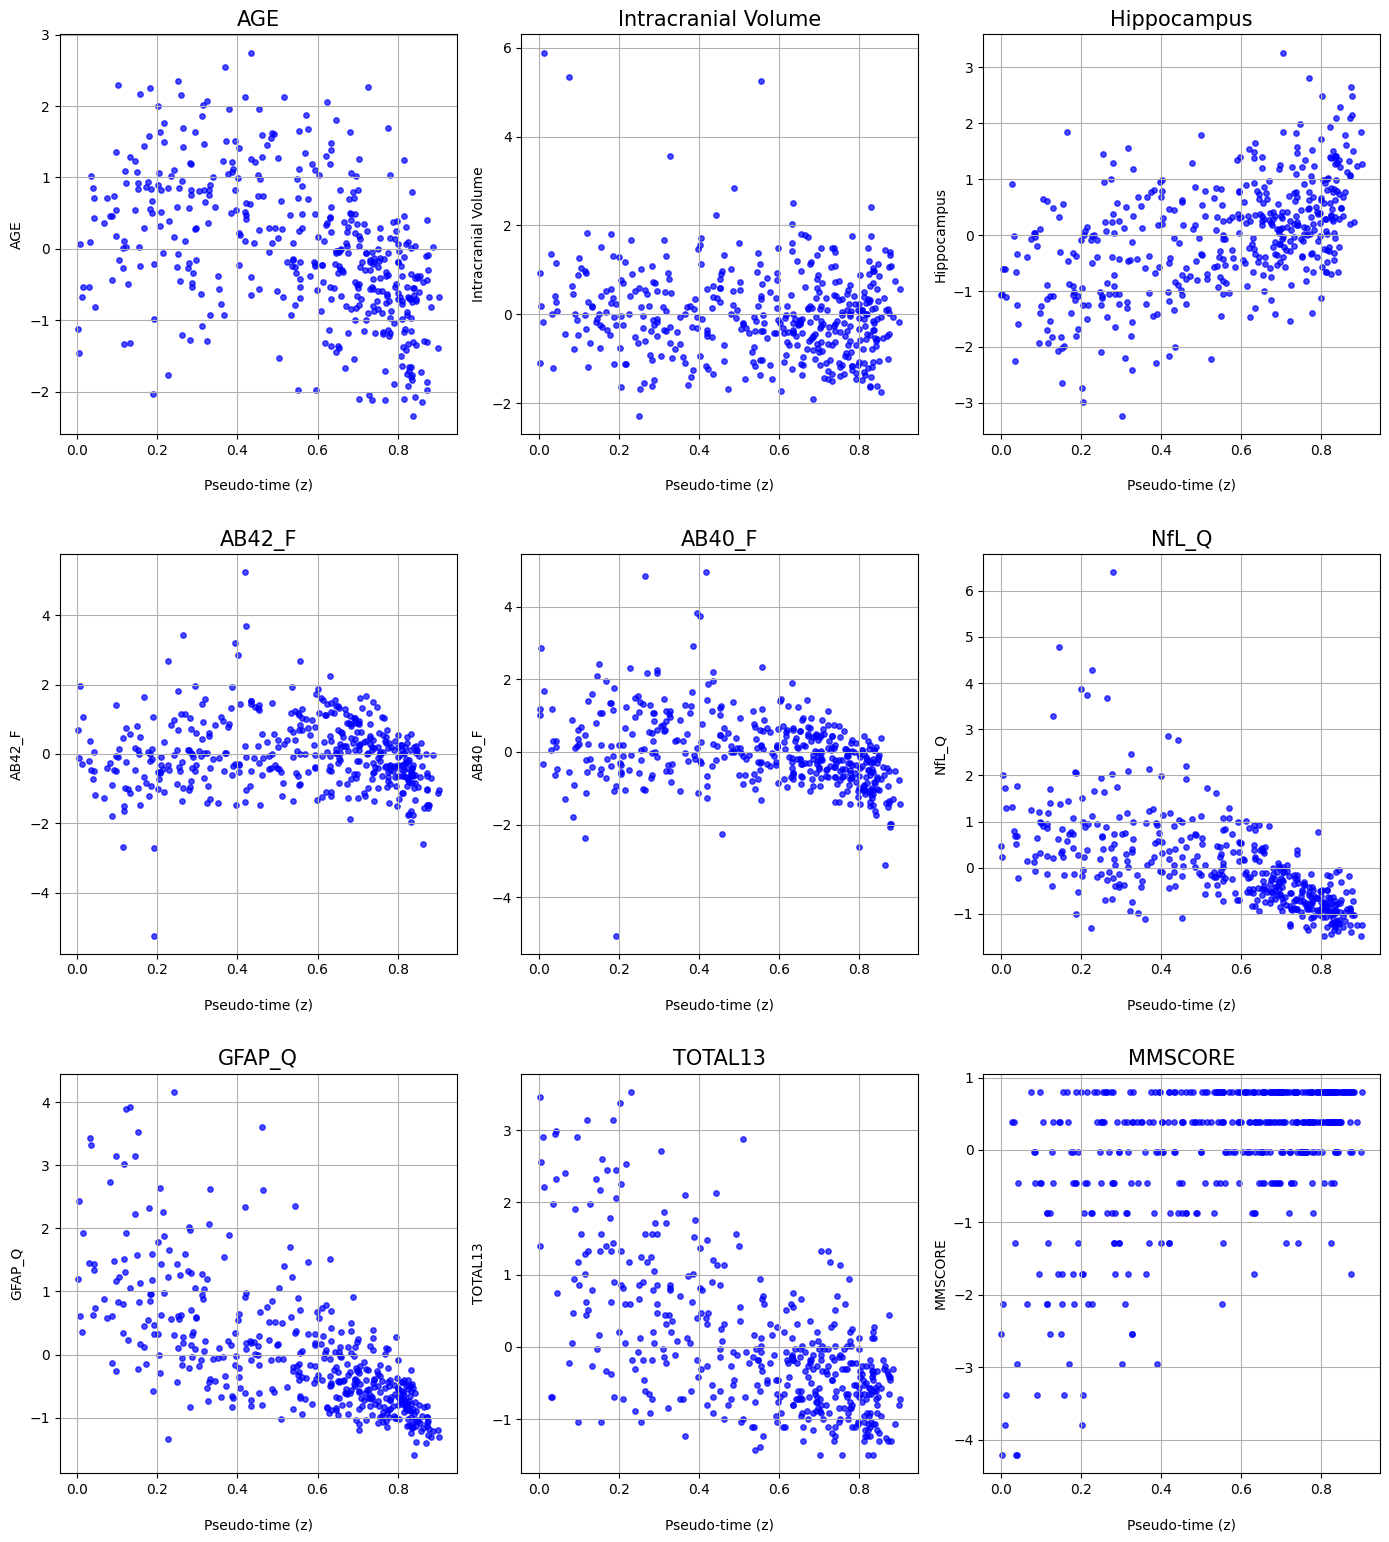

In [14]:
draws1 = chains[2]

# Increase global font size
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

cmap = plt.get_cmap('tab10')

# all_z = np.vstack([ state.z_time[1,:] for state in draws1 ])  

# z_filtered = all_z.mean(axis=0)  

all_z_time = np.vstack([ state.z for state in draws1 ])
z_time_filtered = all_z_time.mean(axis=0)
print

data_filtered = np.array(bb)
fig, axes = plt.subplots(3, 3, figsize=(14, 16), sharex=False)
axes = axes.flatten()
biomarkers = [0,4,5,7,8,9,10,11,-1]  # Adjust to match your data
axis = 0

for i in biomarkers:
    ax = axes[axis]
    axis += 1
    ax.scatter(
        z_time_filtered,
        bb[:, i],
        s=15,
        alpha=0.7,
        c = 'blue',

    )
    # ax.scatter(
    #     z_filtered,
    #     (data_cleaned[1, :, i]),
    #     s=15,
    #     alpha=0.7,
    #     c='orange',

    # )
    ax.set_title(f'{cols[i]}', fontsize=15)
    ax.set_xlabel('Pseudo-time (z)', labelpad=15)
    ax.set_ylabel(f'{cols[i]}', fontsize=10)
    ax.grid(True)


plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.subplots_adjust(hspace=0.3)  # increase vertical spacing

plt.show()

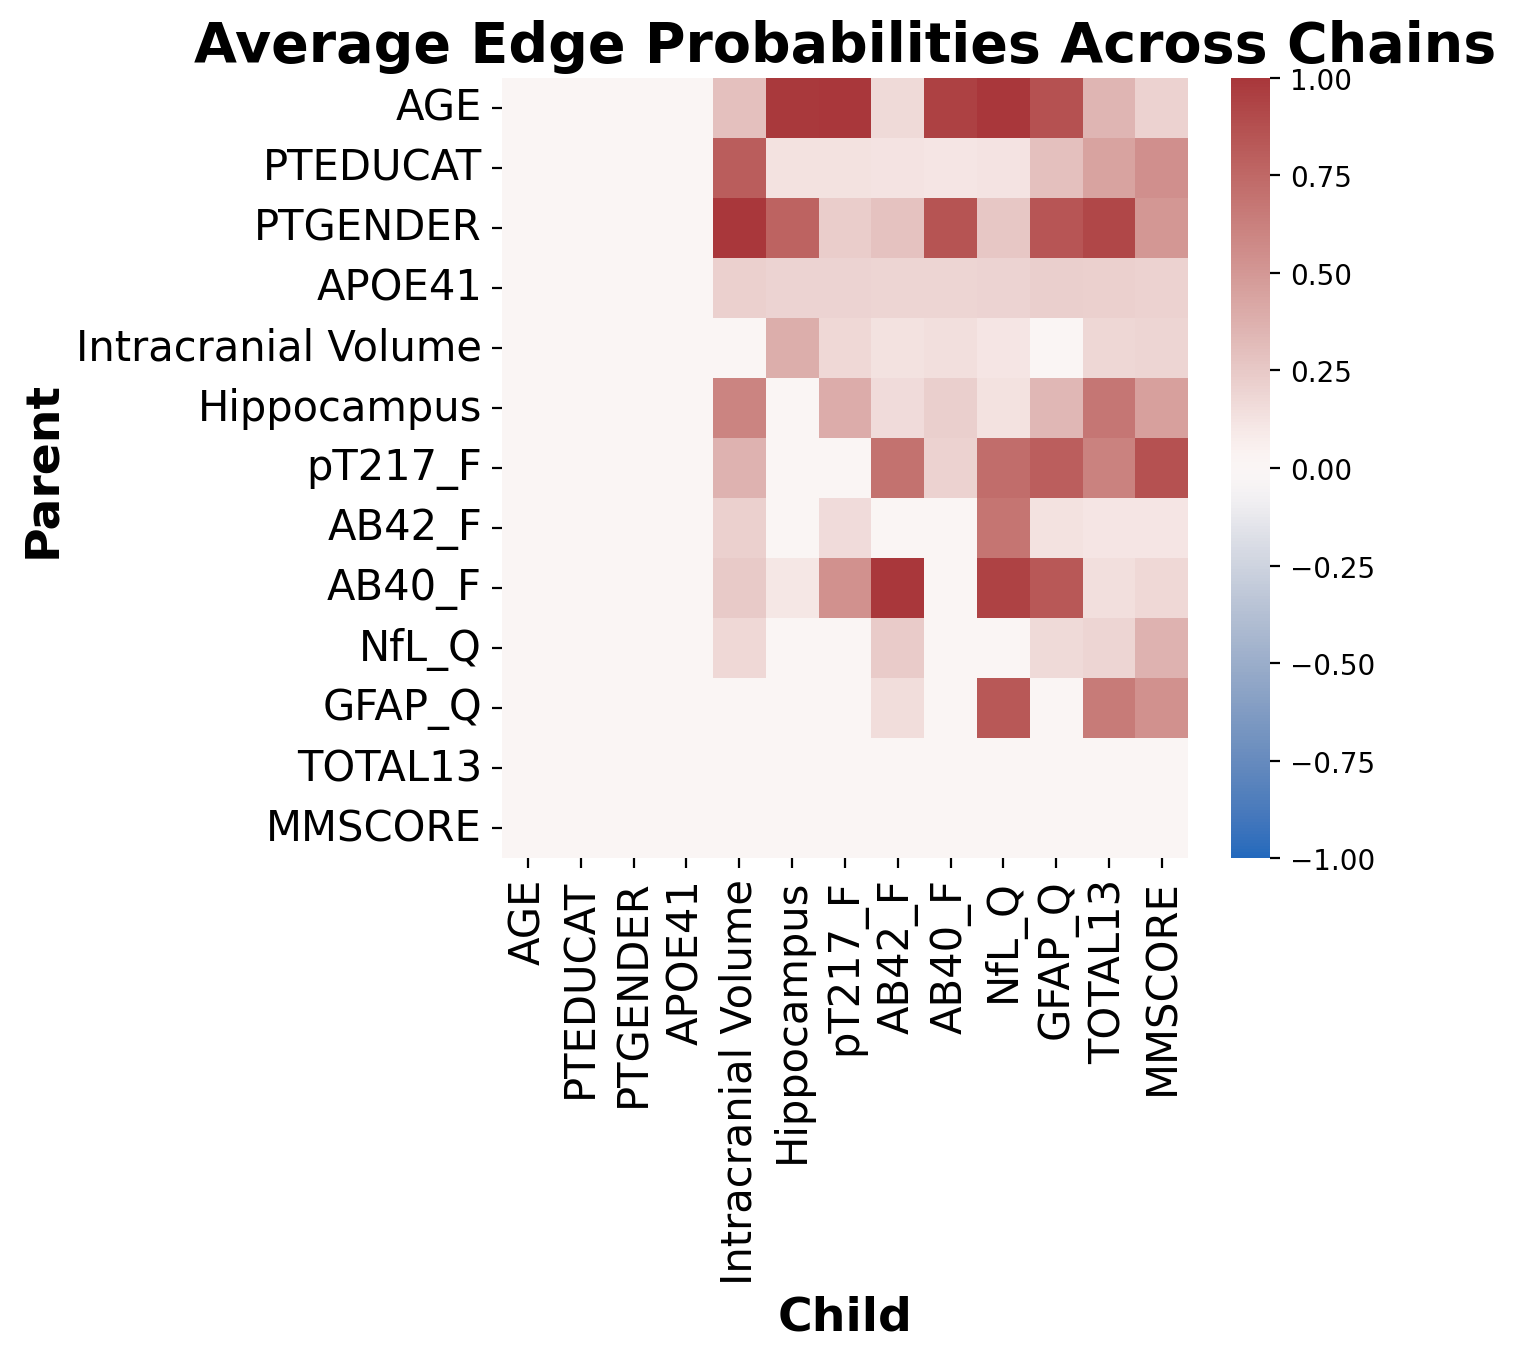

Edge AGE -> Intracranial Volume (0.29485049833887045) is more likely than Intracranial Volume -> AGE (0.0)
Edge PTEDUCAT -> Intracranial Volume (0.8048172757475083) is more likely than Intracranial Volume -> PTEDUCAT (0.0)
Edge PTGENDER -> Intracranial Volume (1.0) is more likely than Intracranial Volume -> PTGENDER (0.0)
Edge APOE41 -> Intracranial Volume (0.2142857142857143) is more likely than Intracranial Volume -> APOE41 (0.0)
Edge Hippocampus -> Intracranial Volume (0.6088039867109635) is more likely than Intracranial Volume -> Hippocampus (0.38953488372093026)
Edge pT217_F -> Intracranial Volume (0.36129568106312293) is more likely than Intracranial Volume -> pT217_F (0.1785714285714286)
Edge AB42_F -> Intracranial Volume (0.21262458471760798) is more likely than Intracranial Volume -> AB42_F (0.13122923588039867)
Edge AB40_F -> Intracranial Volume (0.24501661129568109) is more likely than Intracranial Volume -> AB40_F (0.14451827242524917)
Edge AGE -> Hippocampus (0.98754152823

In [11]:
import seaborn as sns
cmap = sns.cm.vlag
import numpy as np

import matplotlib.pyplot as plt

def compute_average_edge_probabilities(chains, no_incoming=None, forbidden=None, visualize=False, index=1):
    """
    Compute average edge probabilities across multiple MCMC chains.
    
    Parameters
    ----------
    chains : list
        List of MCMC chains, where each chain is a list of StateBS objects from BN_LTE_MCMC_BSpline_Optimized.run.
    no_incoming : np.ndarray, optional
        Boolean array of shape (p,) indicating variables with no incoming edges (static features).
    forbidden : np.ndarray, optional
        Boolean array of shape (p, p) indicating forbidden edges (forbidden[j, l] = True means l → j is not allowed).
    visualize : bool, optional
        If True, plot heatmaps of per-chain and average edge probabilities.
    
    Returns
    -------
    edge_probs_avg : np.ndarray
        Average edge probabilities of shape (p, p), where edge_probs_avg[j, l] is the probability of edge l → j.
    edge_probs_per_chain : list
        List of edge probabilities for each chain, each of shape (p, p).
    
    Raises
    ------
    ValueError
        If chains are empty, have inconsistent dimensions, or contain invalid values.
    """
    index = 0

    if index == 0:
        if not chains or not all(chains):
            raise ValueError("Chains list is empty or contains empty chains")
        
        # Get dimensions from first chain
        p = chains[0][0].r.shape[0]
        K_beta = chains[0][0].r.shape[2]
        
        # Validate inputs
        for chain in chains:
            for state in chain:
                if state.r.shape != (p, p, K_beta):
                    raise ValueError(f"Inconsistent r shape: {state.r.shape}, expected ({p}, {p}, {K_beta})")
                if np.any(np.isnan(state.r)) or np.any(np.isinf(state.r)):
                    raise ValueError("Edge indicators (r) contain NaN or inf values")
        
        # Compute edge probabilities for each chain
        edge_probs_per_chain = []
        for chain in chains:
            # Average r.any(axis=2) across draws in the chain
            edge_probs = np.mean([state.r.any(axis=2) for state in chain], axis=0).T  # Shape: (p, p)
            # edge_probs = np.mean(np.mean([state.r for state in chain], axis=0), axis=2).T  # Shape: (p, p)
            edge_probs_per_chain.append(edge_probs)
        
        # Compute average across chains
        edge_probs_avg = np.mean(edge_probs_per_chain, axis=0)  # Shape: (p, p)
        
        # # Apply constraints
        # if no_incoming is not None:
        #     # if no_incoming.shape != (p,):
        #     #     raise ValueError(f"no_incoming shape {no_incoming.shape} does not match expected ({p},)")
        #     edge_probs_avg[:, no_incoming] = 0  # No incoming edges to static features
        #     for edge_probs in edge_probs_per_chain:
        #         edge_probs[:, no_incoming] = 0
        # if forbidden is not None:
        #     # if forbidden.shape != (p, p):
        #     #     raise ValueError(f"forbidden shape {forbidden.shape} does not match expected ({p}, {p})")
        #     edge_probs_avg[forbidden] = 0  # No forbidden edges
        #     for edge_probs in edge_probs_per_chain:
        #         edge_probs[forbidden] = 0
        


        edge_probs_avg = np.where(edge_probs_avg < 0.1, 0, edge_probs_avg)  # Set small probabilities to 0
        # Visualize if requested
        if visualize:
            plt.figure(figsize=(7, 6 * len(chains)), dpi=200)
            # for i, edge_probs in enumerate(edge_probs_per_chain):
            #     plt.subplot(len(chains) + 1, 1, i + 1)
            #     sns.heatmap(edge_probs, cmap="Blues", vmin=0, vmax=1, cbar=True)
            #     plt.title(f"Edge Probabilities (Chain {i + 1})")
            #     plt.xlabel("Parent (l)")
            #     plt.ylabel("Child (j)")
            
            plt.subplot(len(chains) + 1, 1, len(chains) + 1)
            sns.heatmap(edge_probs_avg, cmap=cmap, vmin=-1, vmax=1, cbar=True, xticklabels=cols, yticklabels=cols)
            plt.title("Average Edge Probabilities Across Chains", fontsize=20, fontweight='bold')
            plt.xlabel("Child", fontsize=17, fontweight='bold')
            plt.ylabel("Parent", fontsize=17, fontweight='bold')
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.tight_layout()
            plt.show()


        # for every edge, find the reverse and find which one is more likely
        for i in range(p):
            for j in range(p):
                if i != j and edge_probs_avg[j, i] > edge_probs_avg[i, j] and edge_probs_avg[j, i] > 0.2:
                    print(f"Edge {cols[j]} -> {cols[i]} ({edge_probs_avg[j, i]}) is more likely than {cols[i]} -> {cols[j]} ({edge_probs_avg[i, j]})")
        
        # Detect direction flips
        flips = []
        for l in range(p):
            for j in range(l + 1, p):
                # if (no_incoming is not None and (no_incoming[j] or no_incoming[l])) or \
                #    (forbidden is not None and (forbidden[j, l] or forbidden[l, j])):
                #     continue
                probs_lj = [edge_probs[j, l] for edge_probs in edge_probs_per_chain]
                probs_jl = [edge_probs[l, j] for edge_probs in edge_probs_per_chain]
                if any(p > 0.5 for p in probs_lj) and any(p > 0.5 for p in probs_jl):
                    flips.append((cols[l], cols[j]))
        if flips:
            print("Edges with potential direction flips:", flips)
        
        index = 1
    
    return edge_probs_avg, edge_probs_per_chain

edge_probs_avg, edge_probs_per_chain = compute_average_edge_probabilities(chains, visualize=True)

Selected patient indices for cohort: [662 205  14 693 477  56 388 225]


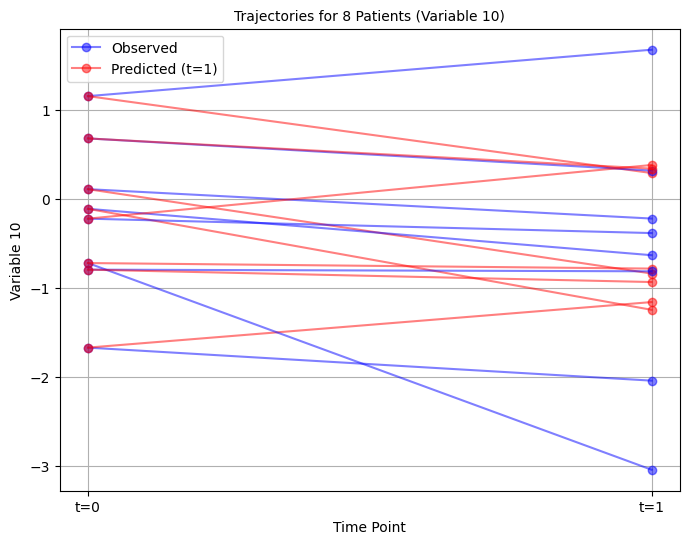

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_patient_trajectories(
    model: sampler,
    variable_idx = 7,
    cohort_size = 10,
    seed = None):
    """
    Plot trajectories for a small cohort of patients for a given variable at two time points.
    
    Args:
        model: Instance of BN_LTE_MCMC_BSpline_Optimized with fitted state.
        variable_idx: Index of the variable to plot (0 <= variable_idx < p).
        cohort_size: Number of patients to sample for plotting (default: 10).
        seed: Random seed for reproducibility in sampling patients (default: None).
    """
    if variable_idx < 0 or variable_idx >= model.p:
        raise ValueError(f"variable_idx must be between 0 and {model.p-1}")

    # Set random seed for reproducibility
    rng = np.random.default_rng(seed)

    # Sample cohort
    valid_patients = np.where(model.valid_time_mask[0] & model.valid_time_mask[1])[0]
    if len(valid_patients) < cohort_size:
        raise ValueError(f"Only {len(valid_patients)} patients have valid data at t=0 and t=1")
    cohort = rng.choice(valid_patients, size=cohort_size, replace=False)
    print(f"Selected patient indices for cohort: {cohort}")

    # Prepare data
    real_t0 = model.X_time[0, cohort, variable_idx]  # Observed at t=0
    real_t1 = model.X_time[1, cohort, variable_idx]  # Observed at t=1

    # Compute predicted values at t=1
    pred_t1 = np.zeros(cohort_size)
    for idx, i in enumerate(cohort):
        z_t1 = model.state.z_time[1, i]
        b_gamma = mcmc_bspline_progress.bspline_basis_single_row(z_t1, K=model.K_gamma, degree=model.degree, t=model.t_gamma)
        b_beta = mcmc_bspline_progress.bspline_basis_single_row(z_t1, K=model.K_beta, degree=model.degree, t=model.t_beta)
        
        baseline = b_gamma @ model.state.gamma[variable_idx]
        edge_sum = 0.0
        for l in range(model.p):
            if l != variable_idx and not model.forbidden[variable_idx, l]:
                coeff = model.state.beta[variable_idx, l] * model.state.r[variable_idx, l]
                if coeff.any():
                    edge_sum += model.X_time[0, i, l] * (b_beta @ coeff)
        pred_t1[idx] = baseline + edge_sum

    # Plotting
    plt.figure(figsize=(8, 6))
    for idx, i in enumerate(cohort):
        # Plot line connecting t=0 to real t=1
        plt.plot([0, 1], [real_t0[idx], real_t1[idx]], 'bo-', alpha=0.5, label='Observed' if idx == 0 else "")
        # Plot predicted t=1 as a separate point
        plt.plot([0,1],[real_t0[idx], pred_t1[idx]], 'ro-', alpha=0.5, label='Predicted (t=1)' if idx == 0 else "")

    plt.xlabel("Time Point")
    plt.ylabel(f"Variable {variable_idx}")
    plt.title(f"Trajectories for {cohort_size} Patients (Variable {variable_idx})")
    plt.xticks([0, 1], ['t=0', 't=1'])
    plt.legend()
    plt.grid(True)
    plt.show()

plot_patient_trajectories(
    model=sampler,
    variable_idx=10,  # Index of the variable to plot
    cohort_size=8,  # Number of patients to sample
    seed=1)          # Random seed for reproducibility

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mcmc_bspline_progress

def visualize_C_effect(sampler, t: int = 0, i: int = 0, save_path: str = None):
    """Visualize the effect of each static variable on z_new.
    
    Args:
        t (int): Time point to evaluate (default 0).
        i (int): Individual to evaluate (default 0).
        save_path (str, optional): Path to save the plot.
    """

    # Get baseline values (mean of normalized static variables)
    v_base = np.nanmean(sampler.V_norm[0, :, :], axis=(0, 1))  # Shape (3,)
    
    # Grid for varying each static variable
    n_points = 100
    v_grid = np.linspace(0, 1, n_points)  # Normalized range [0, 1]
    
    # Labels for static variables
    var_names = [f"Static Var {j}" for j in sampler.var_indices]
    
    # Initialize plot
    plt.figure(figsize=(15, 5))
    
    # Evaluate z_new for each static variable
    for var_idx in range(5):  # For each static variable (0, 1, 2)
        z_values = []
        for v in v_grid:
            # Create input vector with varied variable
            v_input = v_base.copy()
            v_input[var_idx] = v
            c_tensor = mcmc_bspline_progress.additive_basis_row(
                v_input, K=sampler.K_c
            )  # Shape (K_c^3,)
            # Predict z_new
            z_new = c_tensor @ C_average
            # z_new = average_z_time[t, i]
            z_values.append(z_new)

        
        # Convert normalized variable back to original scale for plotting
        v_original = v_grid * (sampler.v_max[var_idx] - sampler.v_min[var_idx]) + sampler.v_min[var_idx]
        
        # Plot
        plt.subplot(1, 3, var_idx + 1)
        plt.plot(v_original, z_values, label=f"Effect on z_new", color="#1f77b4")
        plt.xlabel(var_names[var_idx])
        plt.ylabel("Predicted z_new")
        plt.title(f"Effect of {var_names[var_idx]}")
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    
    # Save or show plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

visualize_C_effect(sampler, t=1, i=1, save_path='C_effects.png')

ModuleNotFoundError: No module named 'mcmc_bspline_progress'

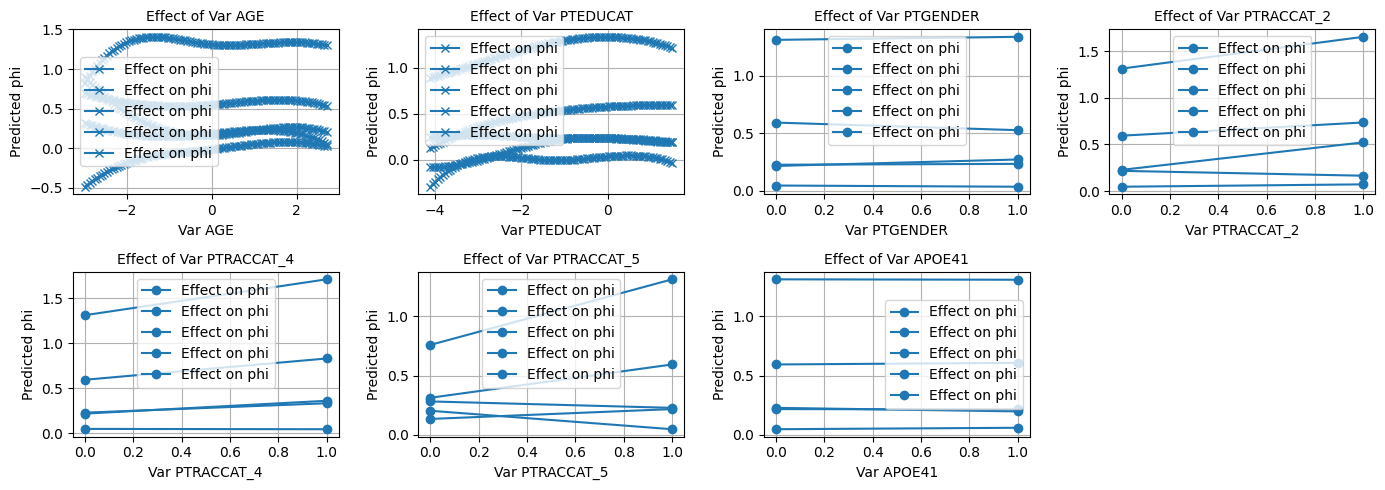

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List
from mcmc_bspline_progress import StateBS  # Adjust import based on your module

def visualize_C_effect(sampler, draws: List[StateBS], t: int = 0, i: int = 0, save_path: Optional[str] = None):
    """Visualize the effect of each static variable on phi for a given subject and time.
    
    Args:
        sampler: Instance of BN_LTE_MCMC_BSpline_Optimized.
        draws: List of StateBS objects from MCMC samples.
        t: Time point to evaluate (default 0).
        i: Individual to evaluate (default 0).
        save_path: Optional path to save the plot.
    """
    # Validate inputs
    if not (0 <= t < sampler.T and 0 <= i < sampler.n):
        raise ValueError(f"Invalid t={t} or i={i}. Must be 0<=t<{sampler.T}, 0<=i<{sampler.n}")
    if not sampler.valid_time_mask[t, i]:
        raise ValueError(f"Subject {i} has invalid data at time {t}")

    # Compute posterior mean of C across draws
    C_average = np.mean([state.C for state in draws], axis=0)  # Shape: (d_total,)

    # Get subject-specific baseline covariates
    v_base = sampler.V_norm[t, i, :]  # Shape: (len(var_indices),)

    # Grid for varying each static variable
    n_points = 100
    v_grid = np.linspace(0, 1, n_points)  # Normalized range [0, 1] for continuous
    v_binary = np.array([0, 1])  # For binary variables

    # Labels for static variables
    var_names = [f"Var {cols[j]}" 
                 for j in sampler.var_indices]

    # Initialize plot
    num_vars = len(sampler.var_indices)
    plt.figure(figsize=(2 * num_vars, 5))

    # Evaluate phi for each static variable
    for var_idx in range(num_vars):
        phi_values = []
        plot_values = v_binary if var_idx in sampler.binary_indices else v_grid
        
        for v in plot_values:
            # Create input vector with varied variable
            v_input = v_base.copy()
            v_input[var_idx] = v
            c_tensor = sampler.mixed_covariate_row(v_input)  # Shape: (d_total,)
            # Predict phi (effect on progression rate)
            phi_pred = c_tensor @ C_average
            phi_values.append(phi_pred)

        # Convert to original scale for continuous variables
        if var_idx in sampler.continuous_indices:
            plot_values = plot_values * (sampler.v_max[var_idx] - sampler.v_min[var_idx]) + sampler.v_min[var_idx]

        # Plot
        plt.subplot(2, int(num_vars/2+0.5), var_idx + 1)
        plt.plot(plot_values, phi_values, label="Effect on phi", color="#1f77b4", marker='o' if var_idx in sampler.binary_indices else 'x')
        plt.xlabel(var_names[var_idx])
        plt.ylabel("Predicted phi")
        plt.title(f"Effect of {var_names[var_idx]}")
        plt.grid(True)
        plt.legend()

    plt.tight_layout()

    # Save or show plot
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# Example usage
# Assuming sampler is your BN_LTE_MCMC_BSpline_Optimized instance and draws is a list of StateBS
# visualize_C_effect(sampler, draws, t=1, i=1, save_path='C_effects.png')

visualize_C_effect(sampler, chain, t=1, i=7, save_path=False)

In [ ]:
all_z = np.vstack([ state.C for state in draws1 ])  

z_filtered = all_z.mean(axis=0) 


AttributeError: 'StateBS' object has no attribute 'C'

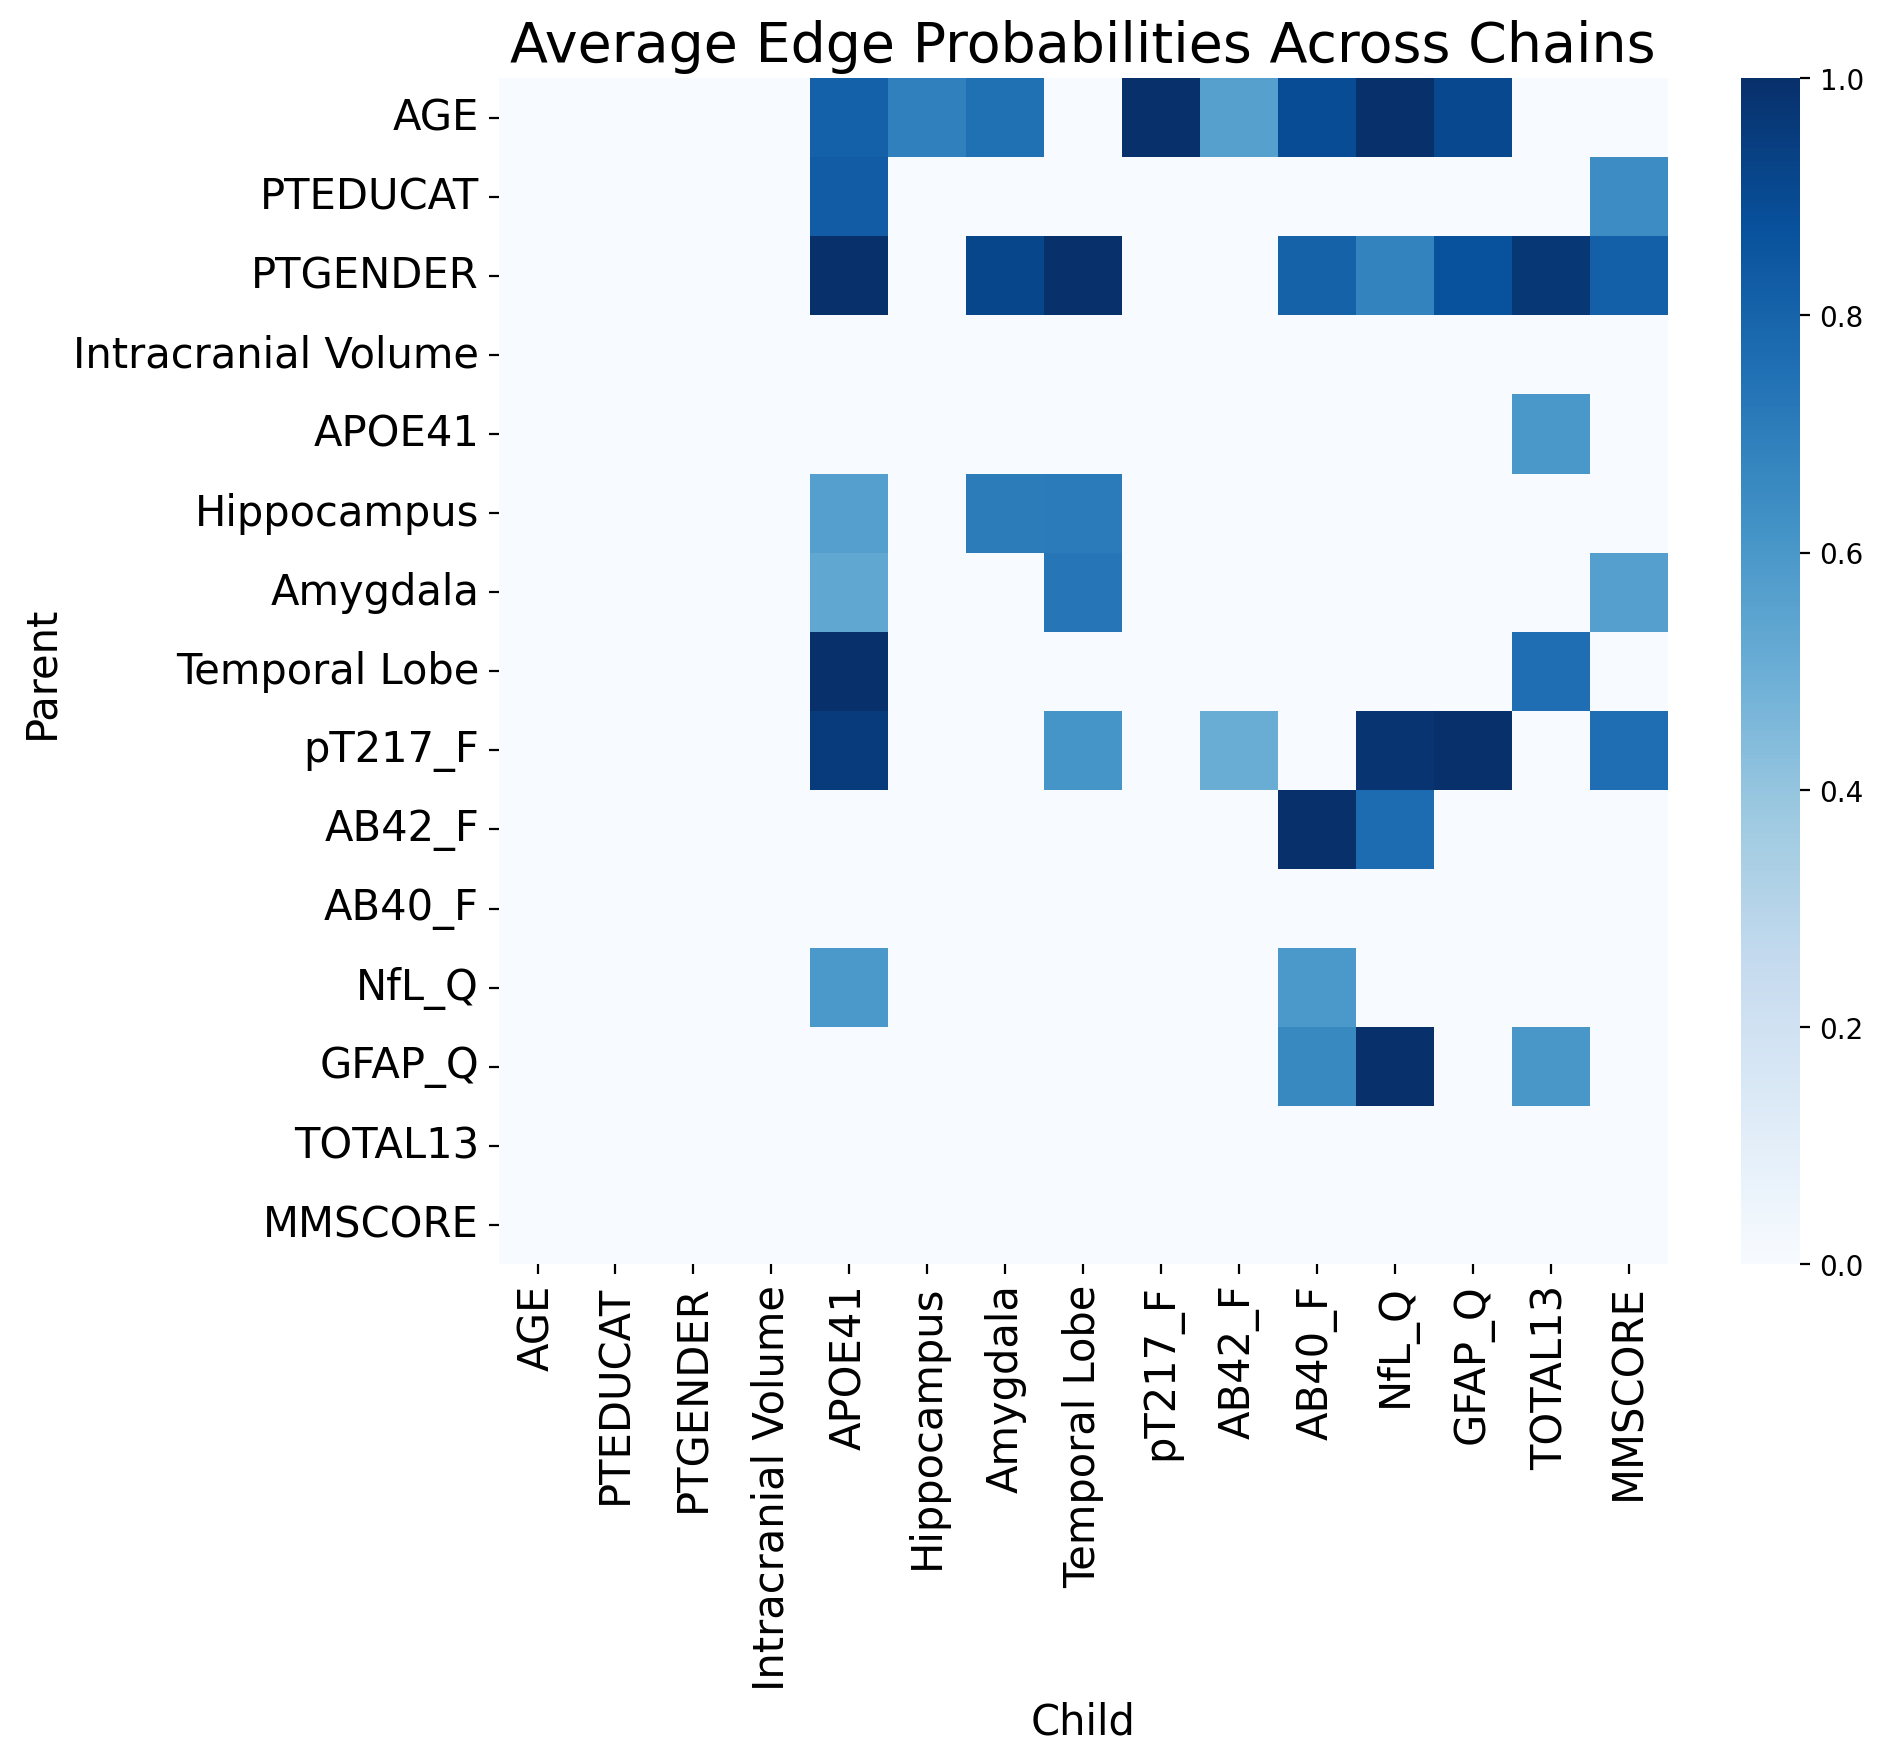

Edge AGE -> APOE41 (0.8093126385809313) is more likely than APOE41 -> AGE (0.0)
Edge PTEDUCAT -> APOE41 (0.8314855875831486) is more likely than APOE41 -> PTEDUCAT (0.0)
Edge PTGENDER -> APOE41 (1.0) is more likely than APOE41 -> PTGENDER (0.0)
Edge Hippocampus -> APOE41 (0.5676274944567627) is more likely than APOE41 -> Hippocampus (0.0)
Edge Amygdala -> APOE41 (0.5343680709534369) is more likely than APOE41 -> Amygdala (0.0)
Edge Temporal Lobe -> APOE41 (1.0) is more likely than APOE41 -> Temporal Lobe (0.0)
Edge pT217_F -> APOE41 (0.9556541019955654) is more likely than APOE41 -> pT217_F (0.0)
Edge NfL_Q -> APOE41 (0.5964523281596452) is more likely than APOE41 -> NfL_Q (0.0)
Edge AGE -> Hippocampus (0.6917960088691796) is more likely than Hippocampus -> AGE (0.0)
Edge AGE -> Amygdala (0.753880266075388) is more likely than Amygdala -> AGE (0.0)
Edge PTGENDER -> Amygdala (0.9157427937915743) is more likely than Amygdala -> PTGENDER (0.0)
Edge Hippocampus -> Amygdala (0.7095343680709

In [12]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_average_edge_probabilities(chains, no_incoming=None, forbidden=None, visualize=False):
    if not chains or not all(chains):
        raise ValueError("Chains list is empty or contains empty chains")
    
    # Get dimensions from first chain
    p = chains[0][0].r.shape[0]
    K_beta = chains[0][0].r.shape[2]
    
    # Validate inputs
    for chain in chains:
        for state in chain:
            if state.r.shape != (p, p, K_beta):
                raise ValueError(f"Inconsistent r shape: {state.r.shape}, expected ({p}, {p}, {K_beta})")
            if np.any(np.isnan(state.r)) or np.any(np.isinf(state.r)):
                raise ValueError("Edge indicators (r) contain NaN or inf values")
    
    # Compute edge probabilities for each chain
    edge_probs_per_chain = []
    for chain in chains:
        # Average r.any(axis=2) across draws in the chain
        edge_probs = np.mean([state.r.any(axis=2) for state in chain], axis=0).T  # Shape: (p, p)
        edge_probs_per_chain.append(edge_probs)
    
    # Compute average across chains
    edge_probs_avg = np.mean(edge_probs_per_chain, axis=0)  # Shape: (p, p)


    edge_probs_avg = np.where(edge_probs_avg < 0.5, 0, edge_probs_avg)  # Set small probabilities to 0
    # Visualize if requested
    if visualize:
        plt.figure(figsize=(10,15), dpi=200)

        plt.subplot(len(chains) + 1, 1, len(chains) + 1)
        sns.heatmap(edge_probs_avg, cmap="Blues", vmin=0, vmax=1, cbar=True, xticklabels=cols, yticklabels=cols)
        plt.title("Average Edge Probabilities Across Chains", fontsize=20)
        plt.xlabel("Child", fontsize=15)
        plt.ylabel("Parent", fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.tight_layout()
        plt.show()


    # for every edge, find the reverse and find which one is more likely
    for i in range(p):
        for j in range(p):
            if i != j and edge_probs_avg[j, i] > edge_probs_avg[i, j] and edge_probs_avg[j, i] > 0.2:
                print(f"Edge {cols[j]} -> {cols[i]} ({edge_probs_avg[j, i]}) is more likely than {cols[i]} -> {cols[j]} ({edge_probs_avg[i, j]})")
    
    # Detect direction flips
    flips = []
    for l in range(p):
        for j in range(l + 1, p):

            probs_lj = [edge_probs[j, l] for edge_probs in edge_probs_per_chain]
            probs_jl = [edge_probs[l, j] for edge_probs in edge_probs_per_chain]
            if any(p > 0.5 for p in probs_lj) and any(p > 0.5 for p in probs_jl):
                flips.append((cols[l], cols[j]))
    if flips:
        print("Edges with potential direction flips:", flips)
    
    return edge_probs_avg, edge_probs_per_chain

edge_probs_avg, edge_probs_per_chain = compute_average_edge_probabilities([chain], visualize=True)

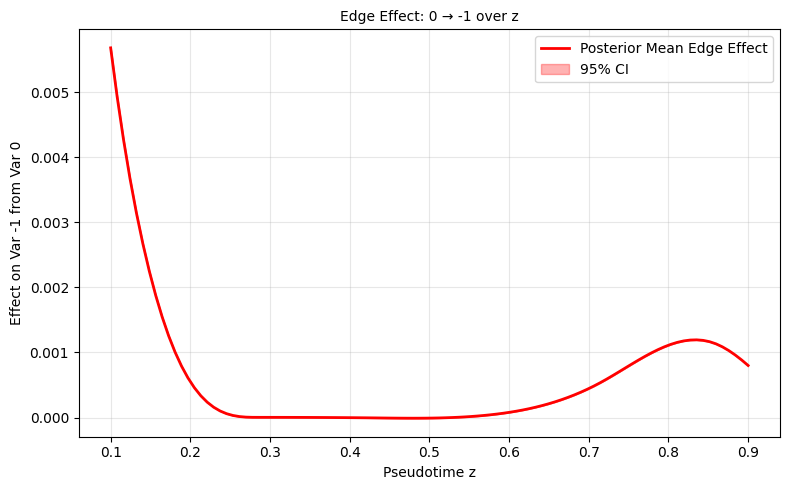

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline  # Assuming already imported in your code

def plot_variable_effect(draws, predictor_idx, response_idx, z_grid=None, scale_by_mean=True):
    """
    Plots the average posterior effect of one variable (predictor) on another (response) over pseudotime z.
    
    Args:
        draws: List[StateBS] from model.run() - posterior samples.
        predictor_idx (int): Index of the predictor variable (l).
        response_idx (int): Index of the response variable (j).
        z_grid (np.ndarray, optional): Grid for pseudotime (0 to 1). Defaults to 100 points.
        scale_by_mean (bool): If True, scale effect by mean(X[:, predictor]) for interpretability.
    
    Returns:
        fig: Matplotlib figure.
    """
    if z_grid is None:
        z_grid = np.linspace(0.1, 0.9, 100)
    
    # Average over posterior: collect phi(z) = basis_beta @ (beta[j,l] * r[j,l])
    n_draws = len(draws)
    K_beta = draws[0].beta.shape[-1]  # Assume consistent
    effects = np.zeros((len(z_grid), n_draws))
    
    # Get knot vector from first state (consistent)
    t_beta = mcmc_bspline_progress._make_t(K_beta, degree=3)  # Assuming degree=3; adjust if needed
    average_beta = np.mean([state.beta for state in draws], axis=0)  # Shape: (p, p, K_beta)
    average_r = np.mean([state.r for state in draws], axis=0)
    
    for i, state in enumerate(draws):
        # Active coefficients for this edge
        active_beta = average_beta[response_idx, predictor_idx] *average_r[response_idx, predictor_idx]
        
        # Basis on grid
        basis_grid = np.zeros((len(z_grid), K_beta))
        for k in range(K_beta):
            coeff_k = np.zeros(K_beta)
            coeff_k[k] = 1.0
            basis_grid[:, k] = BSpline(t_beta, coeff_k, k=3)(z_grid)
        
        # Effect phi(z)
        phi = basis_grid @ active_beta
        effects[:, i] = phi
    
    # Posterior mean effect
    mean_effect = np.mean(effects, axis=1)
    
    # Optional scaling
    if scale_by_mean:
        # Assume access to model.X; pass as arg if needed, or compute from first draw's z
        # For now, placeholder: replace with np.mean(model.X[:, predictor_idx])
        mean_predictor = 1
        mean_effect *= mean_predictor
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(z_grid, mean_effect, 'r-', linewidth=2, label='Posterior Mean Edge Effect')
    
    # Add 95% credible interval
    lower = np.percentile(effects, 5, axis=1)
    upper = np.percentile(effects, 95, axis=1)
    ax.fill_between(z_grid, lower, upper, alpha=0.3, color='red', label='95% CI')
    
    # Overlay raw data: sort by z from first draw (or average z)
    z_data = draws[0].z  # Use first for simplicity; could average
    sort_idx = np.argsort(z_data)
    z_sorted = z_data[sort_idx]
    y_sorted = draws[0].X[sort_idx, response_idx] if hasattr(draws[0], 'X') else None  # Assume state has X? Wait, no—pass model.X
    # Note: To fix, pass model.X or store in StateBS; for now, skip or placeholder
    # if y_sorted is not None:
    #     ax.scatter(z_sorted, y_sorted, alpha=0.5, s=10, color='blue', label='Data')
    
    ax.set_xlabel('Pseudotime z')
    ax.set_ylabel(f'Effect on Var {response_idx} from Var {predictor_idx}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.title(f'Edge Effect: {predictor_idx} → {response_idx} over z')
    plt.tight_layout()
    return fig

# Usage example (after model.run()):
fig = plot_variable_effect(chain, predictor_idx=0, response_idx=-1)
plt.show()
# Note: Update mean_predictor = np.mean(model.X[:, predictor_idx]) inside if passing model.

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


/var/folders/g3/2dtjm6cd09v21m_fw6x_ggx00000gp/T/ipykernel_9909/1304200508.py:12: RuntimeWarning: divide by zero encountered in matmul
  mu = Bz1 @ draw.gamma[j]                 # shape (len(z_vec),)
/var/folders/g3/2dtjm6cd09v21m_fw6x_ggx00000gp/T/ipykernel_9909/1304200508.py:12: RuntimeWarning: overflow encountered in matmul
  mu = Bz1 @ draw.gamma[j]                 # shape (len(z_vec),)
/var/folders/g3/2dtjm6cd09v21m_fw6x_ggx00000gp/T/ipykernel_9909/1304200508.py:12: RuntimeWarning: invalid value encountered in matmul
  mu = Bz1 @ draw.gamma[j]                 # shape (len(z_vec),)
/var/folders/g3/2dtjm6cd09v21m_fw6x_ggx00000gp/T/ipykernel_9909/1304200508.py:17: RuntimeWarning: divide by zero encountered in matmul
  mu += xval * (Bz @ beta)
/var/folders/g3/2dtjm6cd09v21m_fw6x_ggx00000gp/T/ipykernel_9909/1304200508.py:17: RuntimeWarning: overflow encountered in matmul
  mu += xval * (Bz @ beta)
/var/folders/g3/2dtjm6cd09v21m_fw6x_ggx00000gp/T/ipykernel_9909/1304200508.py:17: Runtime

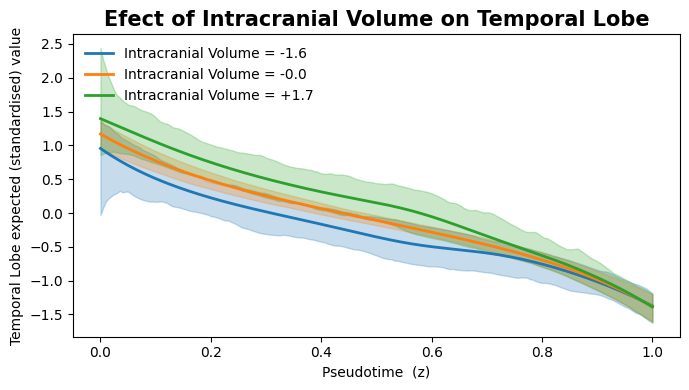

In [ ]:
def expected_curve(draw, j, z_vec, x_static):
    """
    draw      : one posterior StateBS object
    j         : child index
    z_vec     : 1-D array of pseudotime points
    x_static  : dict {parent_index: value}  (standardised scale!)
    """
    print(draw.gamma.shape[-1])
    Bz, _ = bspline_basis(z_vec, K=10)
    Bz1, _ = bspline_basis(z_vec, K=6)
    # baseline
    mu = Bz1 @ draw.gamma[j]                 # shape (len(z_vec),)
    # add static parents
    for l, xval in x_static.items():
        beta  = draw.beta[j, l] * draw.r[j, l]   # active β_k only
        if beta.any():
            mu += xval * (Bz @ beta)
    return mu

# choose the child you want to display and ONE static parent to vary
child  =  10                    # e.g. Tau
parent =  7                   # e.g. Amyloid (static)

# pick "low / mid / high" values on the STANDARDISED scale
x_grid = np.percentile(X[:, parent], [5, 50, 95])
z_grid = np.linspace(0, 1, 200)

plt.figure(figsize=(7, 4))
for x_val, colour in zip(x_grid, ["C0", "C1", "C2"]):
    # stack trajectories across posterior draws
    raw = np.vstack([expected_curve(s, child, z_grid,
                                    {parent: x_val}) for s in chain])
    mean = raw.mean(0)
    lo, hi = np.quantile(raw, [0.05, 0.95], axis=0)

    label = f"{cols[parent]} = {x_val:+.1f}"
    plt.plot(z_grid, mean, color=colour, lw=2, label=label)
    plt.fill_between(z_grid, lo, hi, color=colour, alpha=0.25)

plt.title(f"Efect of {cols[parent]} on {cols[child]}", fontsize=15, fontweight='bold')
plt.xlabel("Pseudotime  (z)")
plt.ylabel(f"{cols[child]} expected (standardised) value")
plt.legend(loc='upper left', frameon=False)
plt.tight_layout()